In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
batch_size = 100
num_classes = 7
input = 16
hidden = 100
num_epochs = 10

In [8]:
df = pd.read_excel("/content/Dry_Bean_Dataset.xlsx")

In [9]:
df

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


###Building a Neural Network

In [10]:
class MLP(nn.Module):
    def __init__(self, input , hidden , num_classes):
        super(MLP, self).__init__()

        self.l1 = nn.Linear(input , hidden )
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden, num_classes)


    def forward(self, x) -> torch.Tensor:
        out1 = self.l1(x)
        out2 = self.relu(out1)
        outf = self.l2(out2)

        return outf

model = MLP(input, hidden, num_classes)

In [ ]:
print(model.parameters())

model.state_dict()

###Loss and Optimizer


In [12]:
Loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model.parameters() , lr= 0.001)

### Custom dataset and Training, vallidation, test split

In [13]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

label_encoder = preprocessing.LabelEncoder()


In [14]:
class custom_dataset(Dataset):
    def __init__(self):
        super(custom_dataset, self).__init__()
        self.df = pd.read_excel("/content/Dry_Bean_Dataset.xlsx")
        self.scaled_data = scaler.fit_transform(self.df.iloc[:, 0:16].values)
        self.labels = label_encoder.fit_transform(df['Class'].values)



    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        X = torch.tensor(self.scaled_data[idx] , dtype= torch.float32)
        Y = torch.tensor(self.labels[idx], dtype = torch.long)

        return X , Y

In [15]:
dataset = custom_dataset()

In [16]:
len(dataset)

13611

In [17]:
train_set, test_set, val_set = torch.utils.data.random_split(dataset, [0.6 , 0.2 , 0.2])

In [18]:
train_loader = torch.utils.data.DataLoader(
      train_set,batch_size=batch_size, shuffle=True
   )

test_loader = torch.utils.data.DataLoader(
      test_set, batch_size=batch_size, shuffle=False
     )

val_loader = torch.utils.data.DataLoader(
      val_set, batch_size=batch_size, shuffle=False
     )

###Training Loop

In [19]:
for epoch in range(10):
    loss = 0
    for i, (features, labels) in enumerate(train_loader):

        features = features.to(device)
        labels = labels.to(device)


        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        #forward pass
        outputs = model(features)

        # compute loss
        train_loss = Loss(outputs, labels)
        print(train_loss,"lol")

        # compute accumulated gradients
        train_loss.backward()

        # parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        print(loss," huu")

    # compute the epoch training loss
    loss = loss / len(train_loader)

    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, 10, loss))

tensor(1.8852, grad_fn=<NllLossBackward0>) lol
1.885239601135254  huu
tensor(1.8167, grad_fn=<NllLossBackward0>) lol
3.7019662857055664  huu
tensor(1.8693, grad_fn=<NllLossBackward0>) lol
5.571231245994568  huu
tensor(1.8619, grad_fn=<NllLossBackward0>) lol
7.4331135749816895  huu
tensor(1.7985, grad_fn=<NllLossBackward0>) lol
9.231640458106995  huu
tensor(1.8359, grad_fn=<NllLossBackward0>) lol
11.067496061325073  huu
tensor(1.7470, grad_fn=<NllLossBackward0>) lol
12.814459562301636  huu
tensor(1.7851, grad_fn=<NllLossBackward0>) lol
14.599597454071045  huu
tensor(1.7092, grad_fn=<NllLossBackward0>) lol
16.30878436565399  huu
tensor(1.6878, grad_fn=<NllLossBackward0>) lol
17.996574759483337  huu
tensor(1.6589, grad_fn=<NllLossBackward0>) lol
19.65548086166382  huu
tensor(1.6029, grad_fn=<NllLossBackward0>) lol
21.258384704589844  huu
tensor(1.6809, grad_fn=<NllLossBackward0>) lol
22.939246654510498  huu
tensor(1.5621, grad_fn=<NllLossBackward0>) lol
24.501323223114014  huu
tensor(1.53

###Training Loop and Validation testing

In [20]:
n_total_steps = len(train_loader)

In [21]:
print(train_loader)

In [22]:
print(n_total_steps)

82


In [32]:
l1 = []
l2 = []


for epoch in range(10):
    loss = 0
    for i, (features, labels) in enumerate(train_loader):


        features = features.to(device)

        labels = labels.to(device)


        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(features)

        # compute training reconstruction loss
        train_loss = Loss(outputs, labels)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        train_loss += train_loss.item()


    # compute the epoch training loss
    loss = train_loss / len(train_loader)
    l1.append(loss)

    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, 10, loss))


    min_valid_loss = np.inf
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for data, labels in val_loader:
        # Transfer Data to GPU if available
        data, labels = data.to(device), labels.to(device)


        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = Loss(target,labels)
        # Calculate Loss
        valid_loss += loss.item()
    l2.append(valid_loss / len(val_loader))

    print(f'Epoch {epoch+1} \n \t\t Training Loss: { train_loss / len(train_loader)} \t\t Validation Loss: { valid_loss / len(val_loader)}')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss



    min_test_loss = np.inf
    test_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer

    correct = 0
    for data, labels in test_loader:
        # Transfer Data to GPU if available
        data, labels = data.to(device), labels.to(device)


        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = Loss(target,labels)
        # Calculate Loss
        test_loss += loss.item()

        correct += (target.argmax(1) == labels).type(torch.float).sum().item()

    l2.append(test_loss / len(test_loader))

    print(f'Epoch {epoch+1} \n \t\t Training Loss: { train_loss / len(train_loader)} \t\t Validation Loss: { valid_loss / len(val_loader)} \t\t Test Loss: {test_loss/len(test_loader)} \t\t Accuracy: {((correct/len(test_loader.dataset))*100):>8f}%')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')



epoch : 1/10, recon loss = 0.00332869
Epoch 1 
 		 Training Loss: 0.0033286912366747856 		 Validation Loss: 0.1967395166201251
Validation Loss Decreased(inf--->5.508706) 	 Saving The Model
Epoch 1 
 		 Training Loss: 0.0033286912366747856 		 Validation Loss: 0.1967395166201251 		 Test Loss: 0.1826850221093212 		 Accuracy: 92.983101%
epoch : 2/10, recon loss = 0.00351050
Epoch 2 
 		 Training Loss: 0.0035105037968605757 		 Validation Loss: 0.19866518356970378
Validation Loss Decreased(inf--->5.562625) 	 Saving The Model
Epoch 2 
 		 Training Loss: 0.0035105037968605757 		 Validation Loss: 0.19866518356970378 		 Test Loss: 0.1849589587322303 		 Accuracy: 92.946363%
epoch : 3/10, recon loss = 0.00303766
Epoch 3 
 		 Training Loss: 0.003037660149857402 		 Validation Loss: 0.19622792463217462
Validation Loss Decreased(inf--->5.494382) 	 Saving The Model
Epoch 3 
 		 Training Loss: 0.003037660149857402 		 Validation Loss: 0.19622792463217462 		 Test Loss: 0.18147033586033753 		 Accuracy: 92.

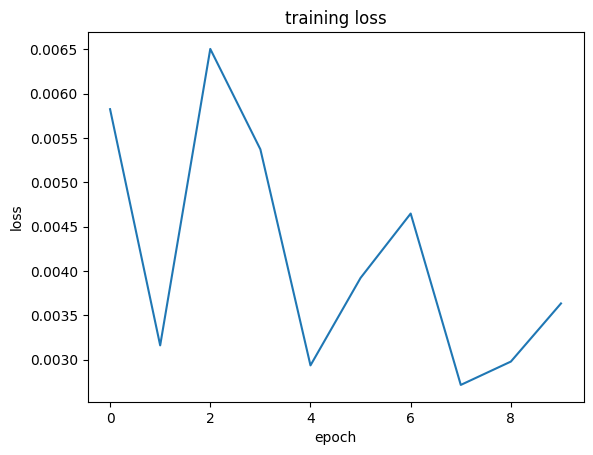

In [28]:
import matplotlib.pyplot as plt

# Assuming l1 is your list or array of loss values
l1_np = [item.detach().numpy() for item in l1]

plt.plot(l1_np)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("training loss")
plt.show()


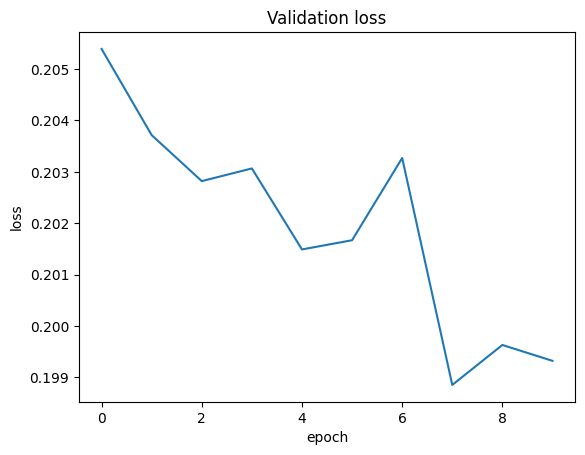

In [31]:
import matplotlib.pyplot as plt

# Assuming l1 is your list or array of loss values
# l2_np = [item.detach().numpy() for item in l2]

plt.plot(l2)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Validation loss")
plt.show()
